# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation(30.0, fill=([255, 255, 255,])),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.ToTensor(),
    transforms.Normalize(
    (0.4914, 0.4822, 0.4465),
    (0.2470, 0.2435, 0.2616)
    )
])

# Test Phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
    (0.4914, 0.4822, 0.4465),
    (0.2470, 0.2435, 0.2616)
    )
])

# Dataset and Creating Train/Test Split

In [3]:
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

batch_size=128
kwargs = {
    'batch_size': batch_size,
    'shuffle': True,
    'num_workers': 4,
    'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

kwargs = {
    'batch_size': 1028,
    'shuffle': False,
    'num_workers': 4,
    'pin_memory': True}
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


# The model
Let's start with the model we first saw

In [4]:
def get_layer(layer_type, in_channel=None, out_channel=None,
              dropout_value=0.05, norm='batch', group=1):
    norm_map = {'batch': nn.BatchNorm2d,
     'layer': nn.GroupNorm,
     'group': nn.GroupNorm}
    norm_layer = norm_map[norm]
    if layer_type == 'C':
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channel,
                      out_channels=out_channel,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            norm_layer(out_channel),
            nn.Dropout(dropout_value)
        )
    elif layer_type == 'c':
        return nn.Conv2d(in_channels=in_channel,
                        out_channels=out_channel,
                        kernel_size=(1, 1), padding=0, bias=False)
    elif layer_type == 'P':
        return nn.MaxPool2d(2, 2)
    elif layer_type == 'G':
        return nn.AdaptiveAvgPool2d(output_size=1)

In [5]:
class Net(nn.Module):
    def __init__(self, schema, channels, norm='batch', dropout_value=0.01):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        for layer_type, channel_in, channel_out in zip(
            schema, [3, *channels], channels):
            self.layers.append(get_layer(
                layer_type, channel_in, channel_out,
                dropout_value, norm))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [6]:
from torchsummary import summary
import model
network = model.Net(
    list('CCcPCCCcPCCCGc'),
    [64, 32, 16, 16,
     32, 16, 32, 16, 16,
     32, 16, 32, 32, 10],
    dropout_value=0.10).to('cpu')
summary(network, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]          18,432
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,608
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1, 32,

# Training and Testing


In [7]:
from torch import optim
from torch.optim.lr_scheduler import StepLR
from model import train, test, plot_loss_n_acc, get_pred_n_actuals
from utils import plot_misclassified_images

device = 'mps:0'
norm = 'batch'
network = model.Net(
    list('CCcPCCCcPCCCGc'),
    [64, 32, 16, 16,
    32, 16, 32, 16, 16,
    32, 16, 32, 32, 10],
    dropout_value=0.10,
    norm='batch').to(device)
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.95)
scheduler = StepLR(optimizer, step_size=6, gamma=0.4)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model.train(network, device, train_loader, optimizer)
    model.test(network, device, test_loader)
    scheduler.step()

EPOCH: 0


Loss=1.4285392761230469 Batch_id=390 Accuracy=35.01: 100%|██████████| 391/391 [00:37<00:00, 10.55it/s]



Test set: Average loss: 1.5295, Accuracy: 4341/10000 (43.41%)

EPOCH: 1


Loss=1.4629215002059937 Batch_id=390 Accuracy=48.15: 100%|██████████| 391/391 [00:36<00:00, 10.57it/s]



Test set: Average loss: 1.3574, Accuracy: 5083/10000 (50.83%)

EPOCH: 2


Loss=1.2037160396575928 Batch_id=390 Accuracy=53.01: 100%|██████████| 391/391 [00:36<00:00, 10.64it/s]



Test set: Average loss: 1.1812, Accuracy: 5668/10000 (56.68%)

EPOCH: 3


Loss=1.1820207834243774 Batch_id=390 Accuracy=56.17: 100%|██████████| 391/391 [00:36<00:00, 10.63it/s]



Test set: Average loss: 1.0974, Accuracy: 6067/10000 (60.67%)

EPOCH: 4


Loss=1.4322525262832642 Batch_id=390 Accuracy=58.66: 100%|██████████| 391/391 [00:36<00:00, 10.66it/s]



Test set: Average loss: 1.0371, Accuracy: 6284/10000 (62.84%)

EPOCH: 5


Loss=1.122915506362915 Batch_id=390 Accuracy=60.02: 100%|██████████| 391/391 [00:36<00:00, 10.82it/s] 



Test set: Average loss: 1.0222, Accuracy: 6369/10000 (63.69%)

EPOCH: 6


Loss=1.097137451171875 Batch_id=390 Accuracy=62.75: 100%|██████████| 391/391 [00:36<00:00, 10.80it/s] 



Test set: Average loss: 0.9034, Accuracy: 6783/10000 (67.83%)

EPOCH: 7


Loss=1.064647912979126 Batch_id=390 Accuracy=63.75: 100%|██████████| 391/391 [00:36<00:00, 10.79it/s] 



Test set: Average loss: 0.9010, Accuracy: 6762/10000 (67.62%)

EPOCH: 8


Loss=0.9372192621231079 Batch_id=390 Accuracy=63.90: 100%|██████████| 391/391 [00:36<00:00, 10.80it/s]



Test set: Average loss: 0.8837, Accuracy: 6858/10000 (68.58%)

EPOCH: 9


Loss=1.1064436435699463 Batch_id=390 Accuracy=64.46: 100%|██████████| 391/391 [00:36<00:00, 10.73it/s]



Test set: Average loss: 0.9094, Accuracy: 6789/10000 (67.89%)

EPOCH: 10


Loss=0.9843314290046692 Batch_id=390 Accuracy=65.22: 100%|██████████| 391/391 [00:36<00:00, 10.81it/s]



Test set: Average loss: 0.8431, Accuracy: 6963/10000 (69.63%)

EPOCH: 11


Loss=0.8611732721328735 Batch_id=390 Accuracy=65.67: 100%|██████████| 391/391 [00:36<00:00, 10.81it/s]



Test set: Average loss: 0.8929, Accuracy: 6809/10000 (68.09%)

EPOCH: 12


Loss=0.8782574534416199 Batch_id=390 Accuracy=66.67: 100%|██████████| 391/391 [00:36<00:00, 10.79it/s]



Test set: Average loss: 0.8214, Accuracy: 7089/10000 (70.89%)

EPOCH: 13


Loss=1.0009081363677979 Batch_id=390 Accuracy=66.85: 100%|██████████| 391/391 [00:36<00:00, 10.79it/s]



Test set: Average loss: 0.8297, Accuracy: 7059/10000 (70.59%)

EPOCH: 14


Loss=1.0376572608947754 Batch_id=390 Accuracy=67.24: 100%|██████████| 391/391 [00:36<00:00, 10.78it/s]



Test set: Average loss: 0.8051, Accuracy: 7175/10000 (71.75%)

EPOCH: 15


Loss=0.888100266456604 Batch_id=390 Accuracy=67.81: 100%|██████████| 391/391 [00:36<00:00, 10.80it/s] 



Test set: Average loss: 0.7990, Accuracy: 7200/10000 (72.00%)

EPOCH: 16


Loss=0.818673312664032 Batch_id=390 Accuracy=67.71: 100%|██████████| 391/391 [00:36<00:00, 10.78it/s] 



Test set: Average loss: 0.8028, Accuracy: 7193/10000 (71.93%)

EPOCH: 17


Loss=0.7098792791366577 Batch_id=390 Accuracy=67.97: 100%|██████████| 391/391 [00:36<00:00, 10.70it/s]



Test set: Average loss: 0.8114, Accuracy: 7160/10000 (71.60%)

EPOCH: 18


Loss=0.9145282506942749 Batch_id=390 Accuracy=68.34: 100%|██████████| 391/391 [00:36<00:00, 10.73it/s]



Test set: Average loss: 0.7920, Accuracy: 7210/10000 (72.10%)

EPOCH: 19


Loss=0.7953512668609619 Batch_id=390 Accuracy=68.63: 100%|██████████| 391/391 [00:36<00:00, 10.79it/s]



Test set: Average loss: 0.7785, Accuracy: 7286/10000 (72.86%)



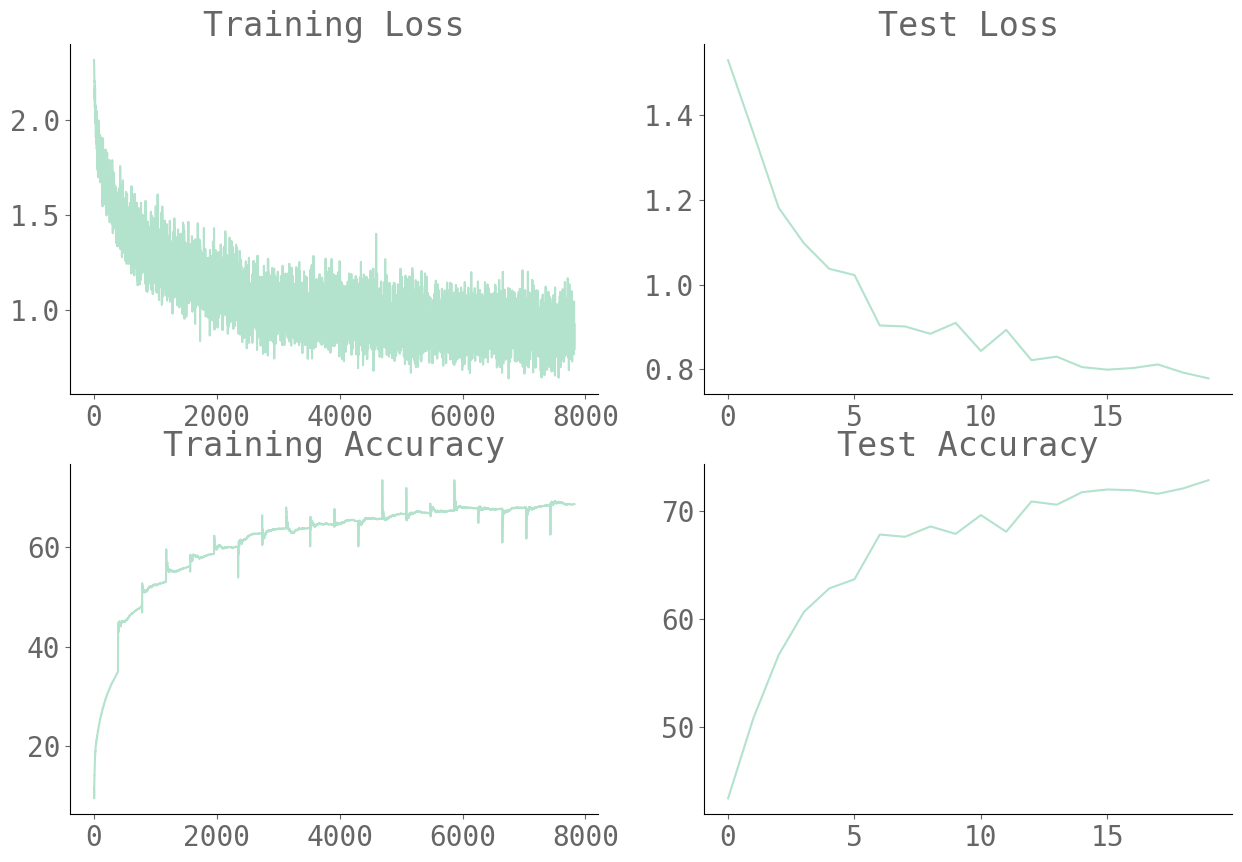

In [8]:
from model import plot_loss_n_acc
plot_loss_n_acc()

In [9]:
labels_df = get_pred_n_actuals(network, test_data, 512, device)


Files already downloaded and verified


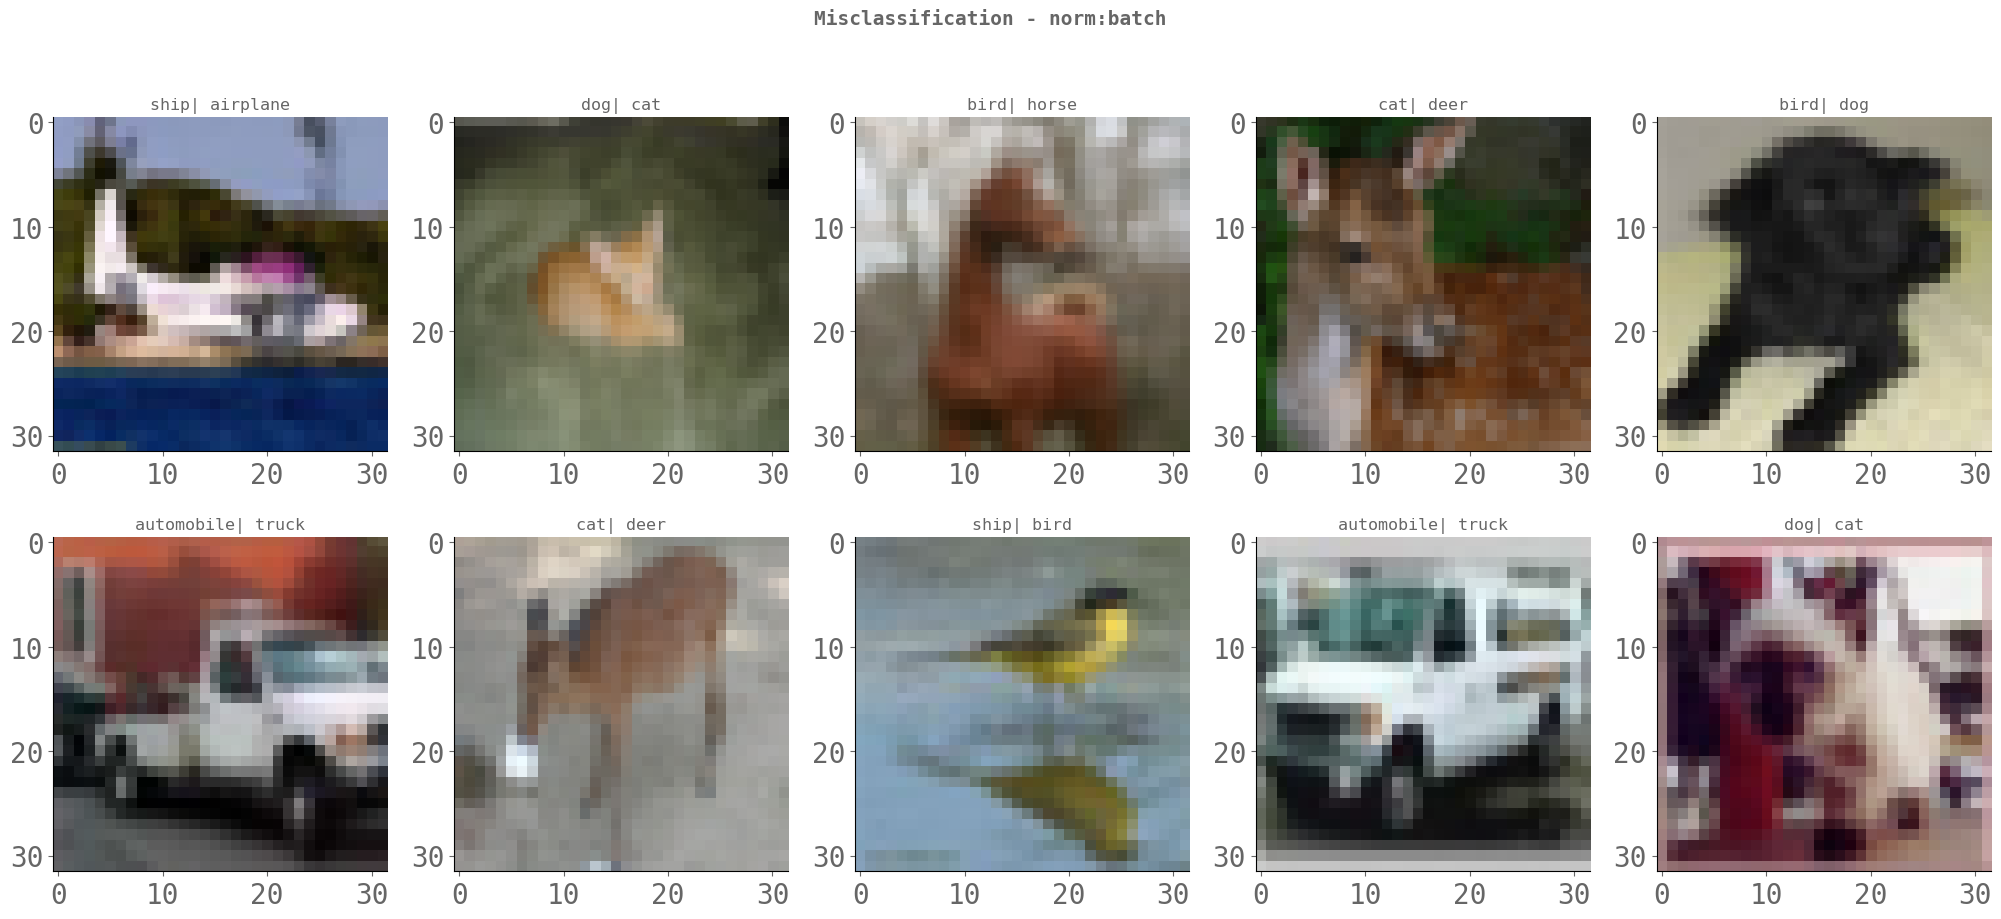

In [10]:
plot_test_data = datasets.CIFAR10('./data', train=False, download=True,)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']
norm = 'batch'
plot_misclassified_images(labels_df, plot_test_data, 
    title=f"Misclassification - norm:{norm}",
    class_labels=class_labels)